# Tutorial 6

## Frequency and time synchronisation

In [1]:
import numpy as np  # make the numpy package available and use 'np' as alias
import scipy.linalg as lin
import matplotlib.pyplot as plt  # plotting library
%matplotlib inline
YOUR_CODE_HERE = None  # placeholder

### Exercise 1
Carry out a data-based frequency synchronization of a PSK transmission!

*Note*: The time synchronization has already been carried out, the optimally samples received symbols are available.

#### a) Generate `N` equiprobable `M`-PSK symbols to be used as a reference sequence.

*Note*: First create the constellation diagram and then use `np.random.choice` to select symbols that are equally likely.

In [2]:
M = 8  # constellation order
N = 100  # lenght of reference sequence

symbol_mapping = YOUR_CODE_HERE
ref_symbols = YOUR_CODE_HERE

# solution
symbol_mapping = np.exp(1j * 2 * np.pi * np.arange(M) / M)
ref_symbols = np.random.choice(symbol_mapping, N)

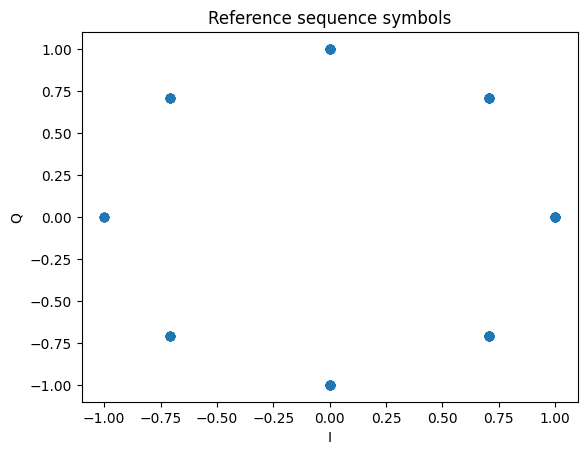

In [3]:
plt.scatter(ref_symbols.real, ref_symbols.imag)
plt.xlabel('I'); plt.ylabel('Q')
plt.title('Reference sequence symbols');

#### b) Simulate the interference by applying a frequency offset of 0.1 Hz and a random phase to the symbol stream.
*Note*: To do this, multiply `ref_seq` by a suitable complex exponential term.

In [4]:
T = 1  # symbol duration in seconds
f_off = YOUR_CODE_HERE
phi_off = YOUR_CODE_HERE
symbols_with_offset = YOUR_CODE_HERE

# solution
f_off = 0.1
phi_off = np.random.random() * 2 * np.pi
symbols_with_offset = ref_symbols * np.exp(1j * 2 * np.pi * f_off * np.arange(N) * T + 1j * phi_off)


#### c) Apart from the influences from b), the channel is an AWGN channel with an SNR of 20 dB. Create a suitable noise realization `noise` and apply it to the receive symbols` recv_symbols`.
*Note*: Think about how you can generate a complex normal distribution with `np.random.randn` and how it has to be scaled. Don't forget to convert the logarithmic representation of the SNR to linear! You can use `np.mean` and` np.var` to check the mean and variance.

In [5]:
SNR_dB = 20
noise_variance_linear = YOUR_CODE_HERE
noise = YOUR_CODE_HERE
recv_symbols = YOUR_CODE_HERE

# solution
noise_variance_linear = 10**(-SNR_dB / 10)
noise = np.sqrt(noise_variance_linear / 2) * (np.random.randn(ref_symbols.size) + 1j*np.random.randn(ref_symbols.size))
print("noise mean/var:", np.mean(noise), "/", np.var(noise))
recv_symbols = symbols_with_offset + noise

noise mean/var: (0.004488500106933863+0.006091587196962969j) / 0.010689581801692003


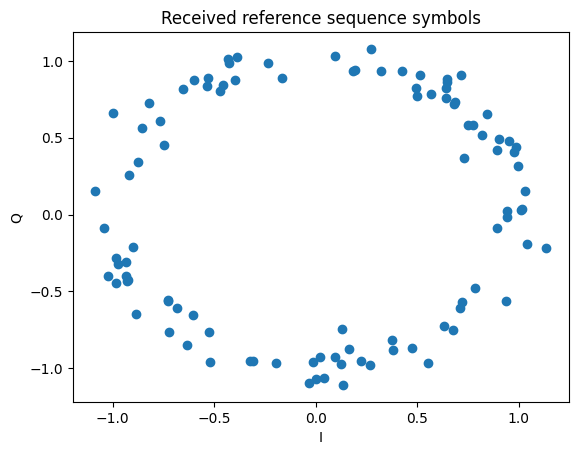

In [6]:
plt.scatter(recv_symbols.real, recv_symbols.imag)
plt.xlabel('I'); plt.ylabel('Q')
plt.title('Received reference sequence symbols');

#### d)Estimate the frequency offset from the noisy received sequence! In the first step, multiply the received sequence point by point with the complex conjugate reference sequence before you determine the frequency offset from the phase.

*1. Note* : What happens to the phase of the data symbols during multiplication?

*2. Note* : Make sure you understand how frequency and phase are related!

In [19]:
y = YOUR_CODE_HERE  # multiply the received signal with the complex conjugated reference sequence
estimated_f_off = YOUR_CODE_HERE

# solution: 
y = np.conj(ref_symbols) * recv_symbols # |s|^2*exp(j*2*pi*f_off*t+j*phi_off)
delta_phi = np.mean(np.angle([y[i] / y[i-1] for i in range(1, y.size)])) # remove dependence on t -> replace with delta_T=T
estimated_f_off = delta_phi/(2*np.pi*T) # remove factors 2*pi*T

# ref solution 1
y = np.conj(ref_symbols) * recv_symbols # |s|^2*exp(j*2*pi*f_off*t+j*phi_off)
delta_phix = np.angle(np.mean([y[i]**M / y[i-1]**M for i in range(1, y.size)])) # remove dependence on t -> replace with delta_T=T
estimated_f_offx = delta_phix/(2*M*np.pi*T) # remove factors 2*pi*T

# comparison solution: non-data aided
y = recv_symbols**M # remove data
delta_phi = np.angle(np.sum([y[i] / y[i-1] for i in range(1, y.size)]))
estimated_f_off2 = delta_phi/(2*M*np.pi*T)

In [20]:
print("Estimated frequency offset data-aided:", estimated_f_off, "Hz")
print("Estimation error:", abs(f_off - estimated_f_off) / f_off * 100, "%")

print("Estimated frequency offset data-aided:", estimated_f_offx, "Hz")
print("Estimation error:", abs(f_off - estimated_f_offx) / f_off * 100, "%")

print("Estimated frequency offset non data-aided:", estimated_f_off2, "Hz")
print("Estimation error non data-aided:", abs(f_off - estimated_f_off2) / f_off * 100, "%")

Estimated frequency offset data-aided: 0.09994619758165946 Hz
Estimation error: 0.05380241834054833 %
Estimated frequency offset data-aided: -0.025915324775692295 Hz
Estimation error: 125.9153247756923 %
Estimated frequency offset non data-aided: -0.022528549893088026 Hz
Estimation error non data-aided: 122.52854989308804 %


### e) Theory questions
1. Which parameter determines the range of correctable frequency offsets? *Answer*: The symbol time `T`.
2. Give the equation for the range of correctable frequency offsets! *Answer:* $|f_{max}| = 1/(2T)$
3. Why does a static phase offset in the received signal have no influence on the frequency estimation? *Answer*: Because we are looking at phase differences.
4. What is the disadvantage of using only one symbol for the duration of the entire sequence? *Answer*: The mean value would result in spectral lines, although a sequence with good autocorrelation properties can also be used for frame synchronization.

### Exercise 2
Implement a feedback system with a Gardner detector for the synchronization of the sampling time!

*Note*: The frequency synchronization has already been carried out successfully.

#### a) Generate a random sequence of BPSK symbols of length `N` with an average power of 1!

In [9]:
N = 1000
symbols = YOUR_CODE_HERE

# solution
symbols = np.random.choice([1, -1], N)

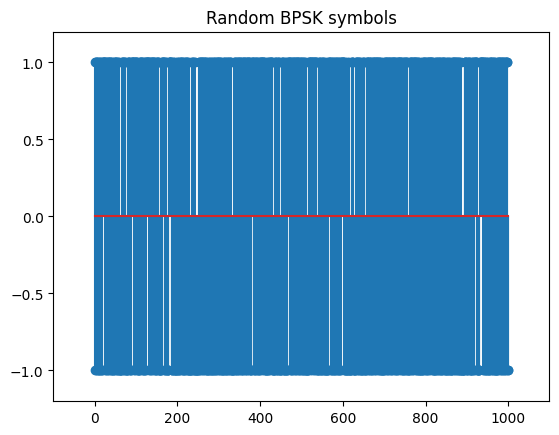

In [10]:
plt.stem(symbols)
plt.title("Random BPSK symbols");
plt.margins(0.1)

#### b) Use the given RRC pulse for pulse shaping! Create both transmitter and receiver filters!
*Note*: Neglect (by removing) the settling time in the end result in order to suppress edge effects!

In [11]:
import rrc  # requires rrc.py to be accessible (e.g., in the same directory)
sps = 16  # samples per symbol
K = 8  # length of the impulse response in symbols
rho = 1  # RRC rolloff factor
g = rrc.get_rrc_ir(K * sps + 1, sps, 1, rho)  # RRC impulse response
g /= lin.norm(g)  # normalize the filter such that the sampled receive symbols have the same mean power

In [12]:
rx_signal = YOUR_CODE_HERE  # baseband receive signal

# solution
symbols_up = np.zeros(N * sps)
symbols_up[::sps] = symbols
tx_signal = np.convolve(g, symbols_up)
rx_signal = np.convolve(g, tx_signal)
group_delay = (g.size - 1) // 2
rx_signal = rx_signal[2 * group_delay: -2 * group_delay]

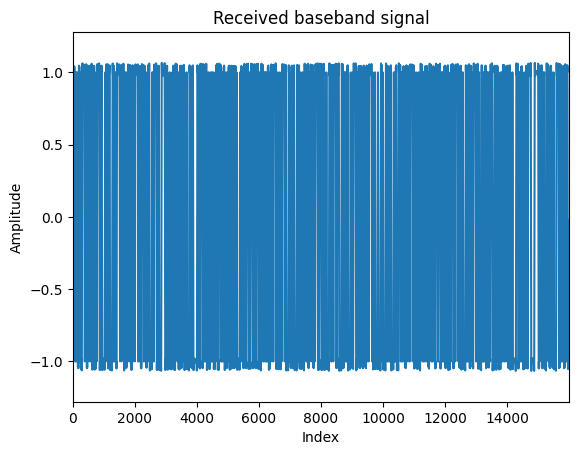

In [13]:
plt.plot(rx_signal)
plt.title("Received baseband signal")
plt.xlabel("Index"); plt.ylabel("Amplitude")
plt.margins(x=0, y=0.1)

#### c) Simulate a time shift by removing the first `n_off` samples.

In [33]:
n_off = sps//2
r = YOUR_CODE_HERE

# solution
r = rx_signal[n_off:]

#### d) Complete the implementation of the timing algorithm by implementing the functions `TED` and` loop_filter`!
*Note 1*: The implementation closely follows the lecture/tutorial slides.

*Note 2*: Use the `rint` function where necessary to convert the float values of `tau` into integer values.

In [34]:
def rint(x):
    return int(np.round(x))

class gardner_timing_recovery:
    e = [0]
    gamma = 0.1
    tau = [0, 0]
    output_symbols = []
    
    def run(self, y):
        for k in range(y.size//sps - 1):
            self.output_symbols.append(y[k*sps + rint(self.tau[k])])
            if k > 0:
                self.e.append(self.TED(y, k))  # update error signal
                self.tau.append(self.loop_filter(k))
    
    def TED(self, y, k):
        return (y[(k-1)*sps + self.rint(self.tau[k-1])] - y[k*sps + rint(self.tau[k])]) * y[k * sps - sps//2 + rint(self.tau[k-1])]
    
    def loop_filter(self, k):
        return self.tau[k] + self.gamma * self.e[k]
    
    def rint(self, x):
        return int(round(x))
    
timing_sync = gardner_timing_recovery()
timing_sync.run(r)
r_sync = timing_sync.output_symbols

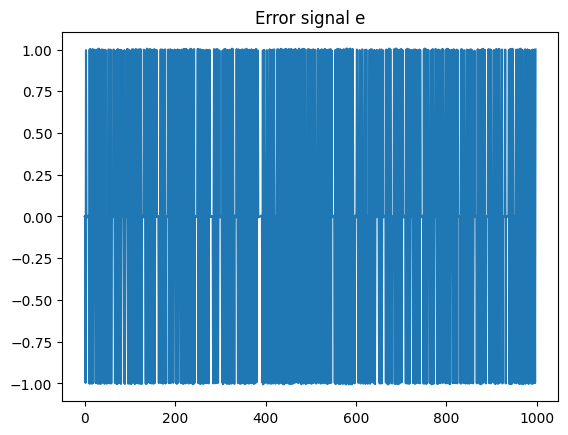

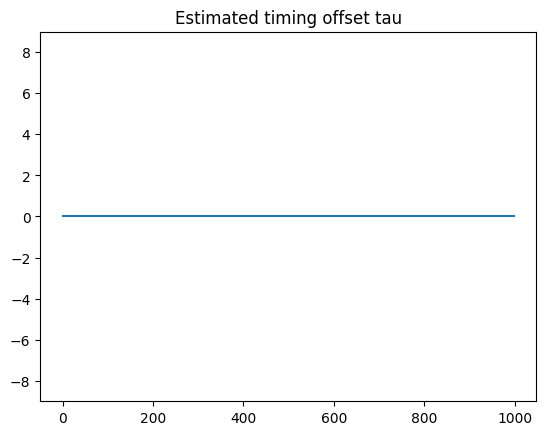

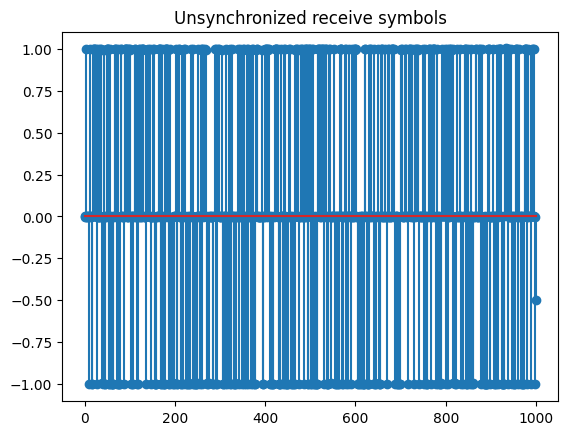

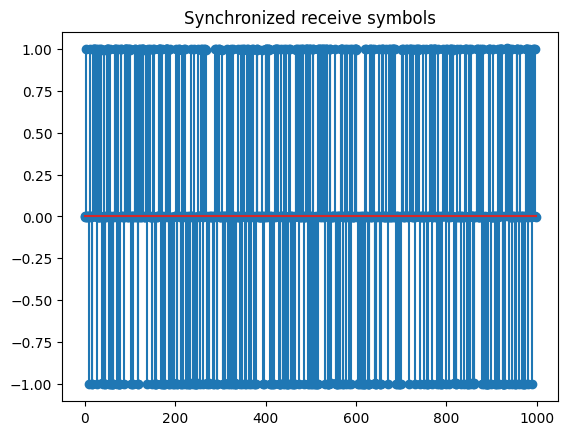

In [35]:
plt.plot(timing_sync.e); plt.title("Error signal e"); plt.show();
plt.plot([rint(tau) for tau in timing_sync.tau]); plt.title("Estimated timing offset tau"); plt.ylim([-sps//2-1, sps//2+1]); plt.show();
plt.stem(r[::sps]); plt.title("Unsynchronized receive symbols"); plt.show();
plt.stem(r_sync); plt.title("Synchronized receive symbols"); plt.show();

#### e)  Theory questions
1. What is the meaning of the parameter `gamma`? What is the trade-off in his choice? *Answer*: It determines the speed of convergence. For small values, the algorithm converges slowly, but with a low estimation variance, while large values quickly approach the optimum, but are not very precise.
2. Can you also use this algorithm to correct time offsets that change over time? *Answer*: Yes, if the change over time is slow compared to the symbol time.
3. The procedure fails if `n_off = sps // 2`. Explain why! Is this a realistic case? Which other influences were neglected in this simulation? *Answer*: In this case the detector is "on the edge" and outputs 0. Since realistic systems always have noise (or drift over time), the detector will usually "tip over" in one of the two directions and then approach the correct sampling time.